In [1]:
import pandas as pd
import numpy as np

In [2]:
bogota = pd.read_csv('bogota.csv')
bogota

,FECHA_DIAGNOSTICO,CASO,CASOS_ACUMULADOS,RECUPERADO,RECUPERADOS_ACUMULADOS,FALLECIDOS,FALLECIDOS_ACUMULADOS
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,0,1,0,1,0,0
4,2020-03-10,2,3,2,3,0,0
...,...,...,...,...,...,...,...
678,2022-01-13,8075,1565063,168,1484374,5,27949
679,2022-01-14,7942,1573005,174,1484548,1,27950
680,2022-01-15,6754,1579759,235,1484783,7,27957
681,2022-01-16,5333,1585092,31,1484814,2,27959


In [3]:
bogota_cases = bogota.drop(['CASO', 'RECUPERADO', 'RECUPERADOS_ACUMULADOS','FALLECIDOS','FALLECIDOS_ACUMULADOS'],axis=1)
bogota_cases

,FECHA_DIAGNOSTICO,CASOS_ACUMULADOS
0,2020-03-06,1
1,2020-03-07,1
2,2020-03-08,1
3,2020-03-09,1
4,2020-03-10,3
...,...,...
678,2022-01-13,1565063
679,2022-01-14,1573005
680,2022-01-15,1579759
681,2022-01-16,1585092


In [4]:
bogota_cases.set_index('FECHA_DIAGNOSTICO', inplace = True)
bogota_cases

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2022-01-13,1565063
2022-01-14,1573005
2022-01-15,1579759


In [5]:
train = bogota_cases[:138]
train

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2020-07-17,63192
2020-07-18,65655
2020-07-19,68127


In [6]:
test = bogota_cases[138:138+14]
test

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-07-22,77437
2020-07-23,79880
2020-07-24,83604
2020-07-25,86717
2020-07-26,89002
2020-07-27,92710
2020-07-28,96653
2020-07-29,99736
2020-07-30,103354


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [9]:
train_scaled =scaler.transform(train)
test_scaled = scaler.transform(test)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
window_size= 30
n_features= 1
batch_size = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  138
Total number of samples in the generated data =  108


In [12]:
x_train, y_train = train_generator[0]
x_train.shape
y_train.shape

(1, 1)

In [13]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=len(test)-1 ,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(test))
print("Total number of sambles in the generated data", len(test_generator))

Total number of samples in the original training data =  14
Total number of sambles in the generated data 1


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

In [15]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 300)           362400    
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
history=model.fit(train_generator, validation_data = test_generator, epochs=100)

Epoch 1/100
108/108 [==============================] - 21s 154ms/step - loss: 0.0471 - root_mean_squared_error: 0.2170 - val_loss: 0.2589 - val_root_mean_squared_error: 0.5088
Epoch 2/100
108/108 [==============================] - 14s 128ms/step - loss: 9.5894e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.3476 - val_root_mean_squared_error: 0.5896
Epoch 3/100
108/108 [==============================] - 16s 145ms/step - loss: 1.3659e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.3434 - val_root_mean_squared_error: 0.5860
Epoch 4/100
108/108 [==============================] - 10s 92ms/step - loss: 1.5410e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.3752 - val_root_mean_squared_error: 0.6125
Epoch 5/100
108/108 [==============================] - 14s 134ms/step - loss: 6.4759e-05 - root_mean_squared_error: 0.0080 - val_loss: 0.3832 - val_root_mean_squared_error: 0.6190
Epoch 6/100
108/108 [==============================] - 15s 135ms/step - loss: 7.2810e-05 - root_mean_squa

In [17]:
model1 = Sequential()
model1.add(SimpleRNN(300, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model1.add(SimpleRNN(300, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 300)           90600     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 300)               180300    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 271,201
Trainable params: 271,201
Non-trainable params: 0
_________________________________________________________________


In [18]:
history1=model1.fit(train_generator, validation_data = test_generator, epochs=100)

Epoch 1/100
108/108 [==============================] - 5s 34ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 1.6734e-04 - val_root_mean_squared_error: 0.0129
Epoch 2/100
108/108 [==============================] - 3s 31ms/step - loss: 3.6865e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.9253e-05 - val_root_mean_squared_error: 0.0044
Epoch 3/100
108/108 [==============================] - 3s 30ms/step - loss: 1.7240e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 4/100
108/108 [==============================] - 3s 30ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 5/100
108/108 [==============================] - 3s 30ms/step - loss: 8.5673e-05 - root_mean_squared_error: 0.0093 - val_loss: 7.6451e-05 - val_root_mean_squared_error: 0.0087
Epoch 6/100
108/108 [==============================] - 3s 31ms/step - loss: 3.3577e-05 - root_mean_squared

In [19]:
model2 = Sequential()
model2.add(GRU(300, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model2.add(GRU(300, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 300)           272700    
                                                                 
 gru_1 (GRU)                 (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 814,801
Trainable params: 814,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
history2=model2.fit(train_generator, validation_data = test_generator, epochs=100)

Epoch 1/100
108/108 [==============================] - 11s 75ms/step - loss: 0.0501 - root_mean_squared_error: 0.2238 - val_loss: 0.3023 - val_root_mean_squared_error: 0.5498
Epoch 2/100
108/108 [==============================] - 8s 73ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 3/100
108/108 [==============================] - 8s 73ms/step - loss: 3.0805e-05 - root_mean_squared_error: 0.0056 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 4/100
108/108 [==============================] - 8s 74ms/step - loss: 3.1280e-05 - root_mean_squared_error: 0.0056 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 5/100
108/108 [==============================] - 8s 76ms/step - loss: 2.8719e-05 - root_mean_squared_error: 0.0054 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 6/100
108/108 [==============================] - 8s 77ms/step - loss: 2.8198e-05 - root_mean_squared_error: 0.0

In [21]:
loss_RNN = history1.history['loss']
val_loss_RNN = history1.history['val_loss']
epochs = range(1,len(loss_RNN)+1)

In [22]:
loss_LSTM = history.history['loss']
val_loss_LSTM = history.history['val_loss']
epochs = range(1,len(loss_LSTM)+1)

In [23]:
loss_GRU = history2.history['loss']
val_loss_GRU = history2.history['val_loss']
epochs = range(1,len(loss_GRU)+1)

In [24]:
import matplotlib.pyplot as plt

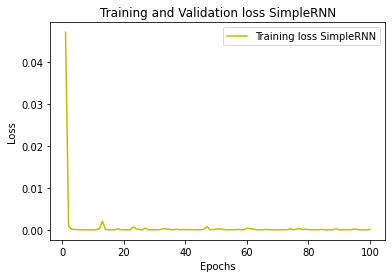

In [25]:
plt.plot(epochs, loss_RNN, 'y',label='Training loss SimpleRNN')
plt.plot(epochs, val_loss_RNN, 'r',label='Validation loss SimpleRNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

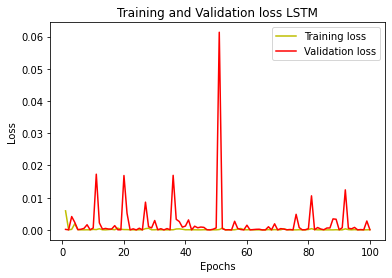

In [26]:
plt.plot(epochs, loss_LSTM, 'y',label='Training loss')
plt.plot(epochs, val_loss_LSTM, 'r',label='Validation loss')
plt.title('Training and Validation loss LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
import numpy as np

predictions_RNN = []
predictions_LSTM = []
predictions_GRU = []

first_batch = train_scaled[-window_size:]
current_batch_RNN = first_batch.reshape((1, window_size, n_features))
current_batch_LSTM = first_batch.reshape((1, window_size, n_features))
current_batch_GRU = first_batch.reshape((1, window_size, n_features))


In [29]:
future = 60
for i in range(future):
    current_pred_RNN = model1.predict(current_batch_RNN)[0]
    current_pred_LSTM = model.predict(current_batch_LSTM)[0]
    current_pred_GRU = model2.predict(current_batch_GRU)[0]

    predictions_RNN.append(current_pred_RNN)
    predictions_LSTM.append(current_pred_LSTM)
    predictions_GRU.append(current_pred_GRU)
    
    current_batch_rmv_first_RNN = current_batch_RNN[:,1:,:]
    current_batch_rmv_first_LSTM = current_batch_LSTM[:,1:,:]
    current_batch_rmv_first_GRU = current_batch_GRU[:,1:,:]

    current_batch_RNN = np.append(current_batch_rmv_first_RNN,[[current_pred_RNN]], axis=1)
    current_batch_LSTM = np.append(current_batch_rmv_first_LSTM,[[current_pred_LSTM]], axis=1)
    current_batch_GRU = np.append(current_batch_rmv_first_GRU,[[current_pred_GRU]], axis=1)

In [30]:
predictions_actual_scale_RNN = scaler.inverse_transform(predictions_RNN)
predictions_actual_scale_LSTM = scaler.inverse_transform(predictions_LSTM)
predictions_actual_scale_GRU = scaler.inverse_transform(predictions_GRU)


test_data_actual_scale = scaler.inverse_transform(test_scaled)
train_data_actual_scale =scaler.inverse_transform(train_scaled)



In [31]:
test_prediction_LSTM=model.predict(test_scaled)
test_prediction_RNN=model1.predict(test_scaled)
test_prediction_GRU=model2.predict(test_scaled)




test_prediction_data_actual_scale_LSTM = scaler.inverse_transform(test_prediction_LSTM)
test_prediction_data_actual_scale_GRU = scaler.inverse_transform(test_prediction_GRU)
test_prediction_data_actual_scale_RNN = scaler.inverse_transform(test_prediction_RNN)


In [32]:
train_data_actual_scale[:,0].shape

(138,)

In [33]:
rng1 = pd.date_range('2020-03-06', periods=138, freq='D')
rng1.shape

(138,)

In [34]:
df = pd.DataFrame({'Date':rng1,'train':train_data_actual_scale[:,0]})
df
df.set_index('Date', inplace = True)
df

,train
Date,
2020-03-06,1.0
2020-03-07,1.0
2020-03-08,1.0
2020-03-09,1.0
2020-03-10,3.0
...,...
2020-07-17,63192.0
2020-07-18,65655.0
2020-07-19,68127.0


In [35]:
rng2 = pd.date_range('2020-07-22', periods=len(test), freq='D')
rng2.shape

(14,)

In [36]:
df2 = pd.DataFrame({'Date':rng2,'Test RNN':test_prediction_data_actual_scale_RNN[:,0],'Test LSTM':test_prediction_data_actual_scale_LSTM[:,0],'Test GRU':test_prediction_data_actual_scale_GRU[:,0]})
df2.set_index('Date', inplace = True)
df2

,Test RNN,Test LSTM,Test GRU
Date,,,
2020-07-22,40054.750000,4554.963379,12594.295898
2020-07-23,41226.621094,4641.118652,12897.123047
2020-07-24,43012.980469,4772.488281,13357.376953
2020-07-25,44505.566406,4882.300781,13741.071289
2020-07-26,45600.730469,4962.772949,14022.831055
2020-07-27,47378.031250,5093.467773,14480.651367
2020-07-28,49268.417969,5232.592773,14968.296875
2020-07-29,50746.503906,5341.479004,15349.898438
2020-07-30,52480.097656,5469.300293,15798.143555


In [37]:
predictions_actual_scale_LSTM[:,0].shape

(60,)

In [38]:
rng3 = pd.date_range('2020-08-04', periods=future, freq='D')
rng3.shape

(60,)

In [39]:
df3 = pd.DataFrame({'Date':rng3,'Predictions_RNN':predictions_actual_scale_RNN[:,0],'Predictions_LSTM':predictions_actual_scale_LSTM[:,0],'Predictions_GRU':predictions_actual_scale_GRU[:,0]})
df3.set_index('Date', inplace = True)
df3

,Predictions_RNN,Predictions_LSTM,Predictions_GRU
Date,,,
2020-08-04,76593.797480,70423.921058,75259.719684
2020-08-05,80039.777239,72626.727686,77972.545271
2020-08-06,83671.335579,74708.015450,80728.936375
2020-08-07,87494.231564,76716.157851,83553.919061
2020-08-08,91499.191085,78685.722418,86455.172081
2020-08-09,95689.448685,80639.429838,89435.149831
2020-08-10,100050.681215,82594.925460,92494.921724
2020-08-11,104605.416516,84564.069273,95636.205839
2020-08-12,109350.551533,86553.181345,98861.351381


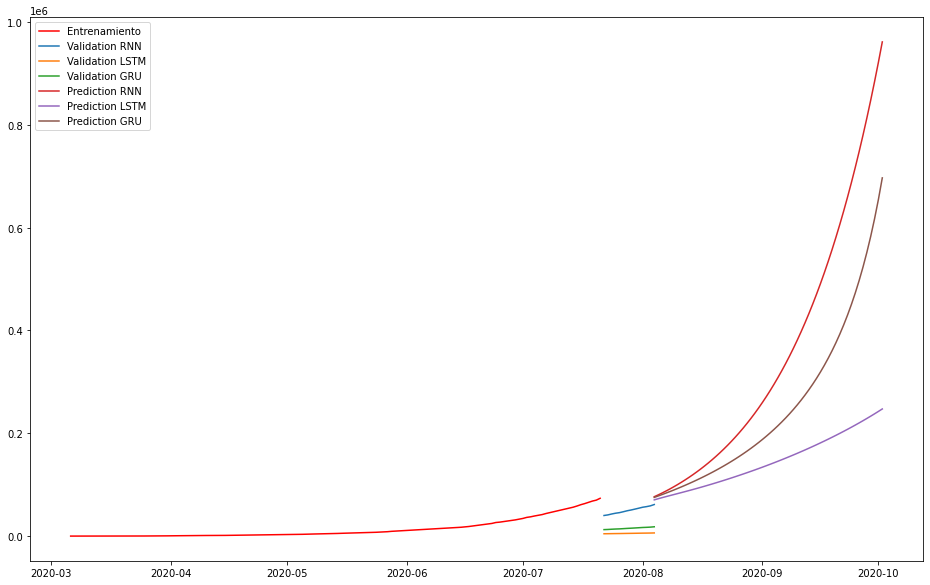

In [46]:
plt.figure(figsize=(16,10))
plt.plot(df,'r', label='Entrenamiento')
plt.plot(df2['Test RNN'], label='Validation RNN')
plt.plot(df2['Test LSTM'], label='Validation LSTM')
plt.plot(df2['Test GRU'], label='Validation GRU')

plt.plot(df3['Predictions_RNN'], label='Prediction RNN')
plt.plot(df3['Predictions_LSTM'], label='Prediction LSTM')
plt.plot(df3['Predictions_GRU'], label='Prediction GRU')
plt.legend()

In [41]:
dff = pd.DataFrame=({'Actual':test_data_actual_scale[:,0],'Prediction':test_prediction_data_actual_scale_RNN[:,0]})
dff

{'Actual': array([ 77437.,  79880.,  83604.,  86717.,  89002.,  92710.,  96653.,
         99736., 103354., 107086., 110960., 113427., 116606., 121973.]),
 'Prediction': array([40054.75 , 41226.62 , 43012.98 , 44505.566, 45600.73 , 47378.03 ,
        49268.418, 50746.504, 52480.098, 54267.44 , 56123.438, 57305.734,
        58829.26 , 61401.38 ], dtype=float32)}

In [42]:
import tensorflow as tf
mse = tf.keras.losses.MeanSquaredError()

In [43]:
mse(dff['Actual'],dff['Prediction'])

<tf.Tensor: shape=(), dtype=float32, numpy=2389039400.0>